# Notebook for Data Exploration of Aachen dataset

In [17]:
import numpy as np
import pandas as pd
import mat4py as mpy

import matplotlib.pyplot as plt

import plotly.graph_objects as go

In [9]:
file_path = '/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/data/Degradation_Prediction_Dataset_ISEA.mat'

In [10]:
# --- 1) Load and transform the raw data from .mat into a Pandas DataFrame ---
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

def compute_eol_and_rul80(row):
    """
    Compute EOL80 (End of Life where capacity drops below 80% of initial)
    and RUL80 (Remaining Useful Life at 80% capacity).
    """
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    eol80_cycle = np.nan
    rul80 = np.nan

    # Handle cases with missing data in historical capacity or cycles
    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    # Determine the threshold for EOL80
    initial_capacity = history_cap[0]
    threshold = 0.8 * initial_capacity

    # Check if the historical capacity already falls below the threshold
    if history_cap[-1] <= threshold:
        return pd.Series({"EOL80": np.nan, "RUL80": np.nan})

    # Handle cases with missing target data
    if len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    # Find the first cycle where capacity drops below the threshold in the target portion
    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol80_index = below_threshold_indices[0]
        eol80_cycle = target_cycles[eol80_index]

    # Calculate RUL80 as the difference between EOL80 and the last history cycle
    if not pd.isna(eol80_cycle):
        last_history_cycle = history_cycles[-1]
        rul80 = eol80_cycle - last_history_cycle

    return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

# Compute EOL80 and RUL80 for each row
df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)

# Filter out rows with invalid RUL80 values (NaN, etc.)
df_valid = df[df["RUL80"].notna()]

In [11]:
df_valid

,Cell,Sample,History_Cycle,History,Target_Cycle_Expanded,Target_expanded,Target_Cycle,Target,EOL80,RUL80
0,1,1,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[105, 110, 115, 120, 125, 130, 135, 140, 145, ...","[1.7973466099593307, 1.7957194104838883, 1.794...","[105, 150, 195, 240, 285, 330, 375, 420, 465, ...","[1.7973466099593307, 1.7832393947563925, 1.770...",1160.0,1060.0
1,1,2,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[110, 115, 120, 125, 130, 135, 140, 145, 150, ...","[1.7957194104838883, 1.794106179214274, 1.7925...","[110, 155, 200, 245, 290, 335, 380, 425, 470, ...","[1.7957194104838883, 1.7817527911332156, 1.769...",1160.0,1055.0
2,1,3,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[115, 120, 125, 130, 135, 140, 145, 150, 155, ...","[1.794106179214274, 1.7925073295393719, 1.7909...","[115, 160, 205, 250, 295, 340, 385, 430, 475, ...","[1.794106179214274, 1.7802836132202329, 1.7676...",1160.0,1050.0
3,1,4,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[120, 125, 130, 135, 140, 145, 150, 155, 160, ...","[1.7925073295393719, 1.7909232748480652, 1.789...","[120, 165, 210, 255, 300, 345, 390, 435, 480, ...","[1.7925073295393719, 1.7788295719024707, 1.766...",1160.0,1045.0
4,1,5,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[125, 130, 135, 140, 145, 150, 155, 160, 165, ...","[1.7909232748480652, 1.7893544285292378, 1.787...","[125, 170, 215, 260, 305, 350, 395, 440, 485, ...","[1.7909232748480652, 1.7773897124807985, 1.765...",1160.0,1040.0
...,...,...,...,...,...,...,...,...,...,...
10660,47,10661,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.84724471159825, 1.845306403634897, 1.843378...","[1090, 1095, 1100, 1105, 1110, 1115, 1120, 112...","[1.490657822471124, 1.4869719936046606, 1.4832...","[1090, 1135, 1180, 1225, 1270, 1315, 1360, 140...","[1.490657822471124, 1.4559932133045455, 1.4167...",1110.0,25.0
10661,47,10662,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.84724471159825, 1.845306403634897, 1.843378...","[1095, 1100, 1105, 1110, 1115, 1120, 1125, 113...","[1.4869719936046606, 1.4832618921167535, 1.479...","[1095, 1140, 1185, 1230, 1275, 1320, 1365, 141...","[1.4869719936046606, 1.4518588129722765, 1.412...",1110.0,20.0
10662,47,10663,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.84724471159825, 1.845306403634897, 1.843378...","[1100, 1105, 1110, 1115, 1120, 1125, 1130, 113...","[1.4832618921167535, 1.4795291195984899, 1.475...","[1100, 1145, 1190, 1235, 1280, 1325, 1370, 141...","[1.4832618921167535, 1.447666140786631, 1.4074...",1110.0,15.0
10663,47,10664,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.84724471159825, 1.845306403634897, 1.843378...","[1105, 1110, 1115, 1120, 1125, 1130, 1135, 114...","[1.4795291195984899, 1.4757613546910484, 1.471...","[1105, 1150, 1195, 1240, 1285, 1330, 1375, 142...","[1.4795291195984899, 1.4434160476754425, 1.402...",1110.0,10.0


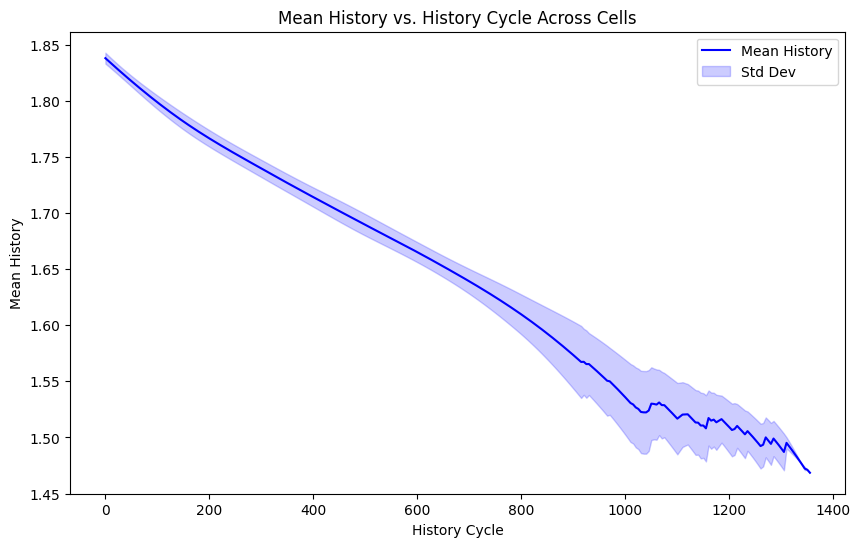

In [12]:
# Create a dictionary to store aggregated data
history_agg = {}

# Find the maximum cell id from df_valid
max_cell_id = df_valid["Cell"].max()

# Loop through all the cells
for i in range(1, max_cell_id + 1):
    # Filter data for the current cell
    df_cell_i = df_valid[df_valid["Cell"] == i]
    
    # Get the last sample for this cell
    last_sample = df_cell_i.iloc[-1]
    
    # Extract history and history_cycle arrays
    history_data = np.array(last_sample["History"])
    history_cycle = np.array(last_sample["History_Cycle"])
    
    # Add to the aggregation dictionary by appending target values per cycle
    for cycle, value in zip(history_cycle, history_data):
        if cycle not in history_agg:
            history_agg[cycle] = []
        history_agg[cycle].append(value)

# Compute mean and standard deviation for each cycle
aggregated_data = {
    "History_Cycle": [],
    "Mean_History": [],
    "Std_History": []
}

for cycle, values in sorted(history_agg.items()):  # Sort by cycle index
    aggregated_data["History_Cycle"].append(cycle)
    aggregated_data["Mean_History"].append(np.mean(values))
    aggregated_data["Std_History"].append(np.std(values))

# Convert the aggregated dictionary to a DataFrame for easier plotting
aggregated_df = pd.DataFrame(aggregated_data)

# Plot the mean with error bars (standard deviation)
plt.figure(figsize=(10, 6))
plt.plot(aggregated_df["History_Cycle"], aggregated_df["Mean_History"], label="Mean History", color="blue")
plt.fill_between(
    aggregated_df["History_Cycle"],
    aggregated_df["Mean_History"] - aggregated_df["Std_History"],
    aggregated_df["Mean_History"] + aggregated_df["Std_History"],
    color="blue",
    alpha=0.2,
    label="Std Dev"
)

# Customize the plot
plt.xlabel("History Cycle")
plt.ylabel("Mean History")
plt.title("Mean History vs. History Cycle Across Cells")
plt.legend()
plt.show()

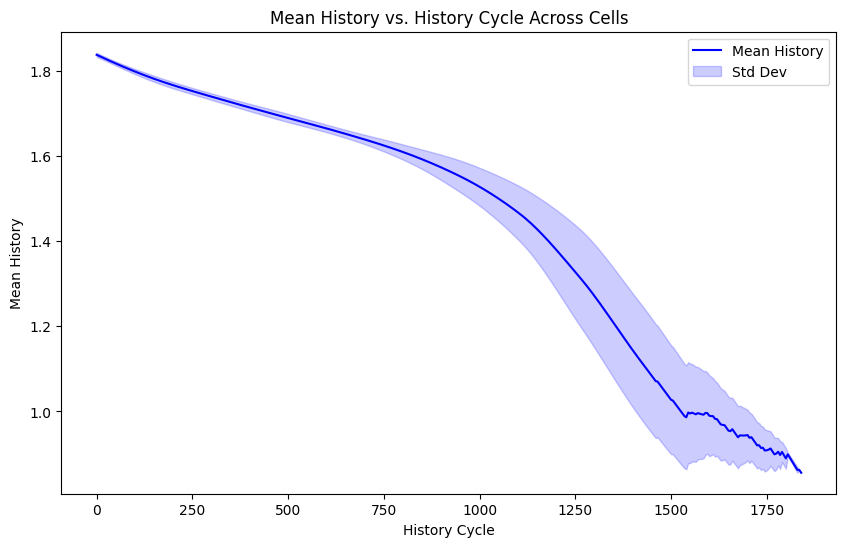

In [14]:
# Create a dictionary to store aggregated data
history_agg = {}

# Find the maximum cell id from df_valid
max_cell_id = df_valid["Cell"].max()

# Loop through all the cells
for i in range(1, max_cell_id + 1):
    # Filter data for the current cell
    df_cell_i = df_valid[df_valid["Cell"] == i]
    
    # Get the last sample for this cell
    last_sample = df_cell_i.iloc[-1]
    
    # Extract history and history_cycle arrays
    history_data = np.array(last_sample["History"])
    history_cycle = np.array(last_sample["History_Cycle"])
    
    # Extract target and target_cycle arrays
    target_data = np.array(last_sample["Target_expanded"])
    target_cycle = np.array(last_sample["Target_Cycle_Expanded"])
    
    # Concatenate the history and target arrays
    value_data = np.concatenate((history_data, target_data), axis=0)
    cycle_data = np.concatenate((history_cycle, target_cycle), axis=0)
    
    # Add the values to the aggregation dictionary by cycle
    for cycle, value in zip(cycle_data, value_data):
        if cycle not in history_agg:
            history_agg[cycle] = []
        history_agg[cycle].append(value)

# Compute mean and standard deviation for each cycle
aggregated_data = {
    "History_Cycle": [],
    "Mean_History": [],
    "Std_History": []
}

for cycle, values in sorted(history_agg.items()):  # Sort by cycle index
    aggregated_data["History_Cycle"].append(cycle)
    aggregated_data["Mean_History"].append(np.mean(values))
    aggregated_data["Std_History"].append(np.std(values))

# Convert the aggregated data into a DataFrame for easier plotting
aggregated_df = pd.DataFrame(aggregated_data)

# Plot the mean with error bars (standard deviation)
plt.figure(figsize=(10, 6))
plt.plot(aggregated_df["History_Cycle"], aggregated_df["Mean_History"], label="Mean History", color="blue")
plt.fill_between(
    aggregated_df["History_Cycle"],
    aggregated_df["Mean_History"] - aggregated_df["Std_History"],
    aggregated_df["Mean_History"] + aggregated_df["Std_History"],
    color="blue",
    alpha=0.2,
    label="Std Dev"
)

# Customize the plot
plt.xlabel("History Cycle")
plt.ylabel("Mean History")
plt.title("Mean History vs. History Cycle Across Cells")
plt.legend()
plt.show()

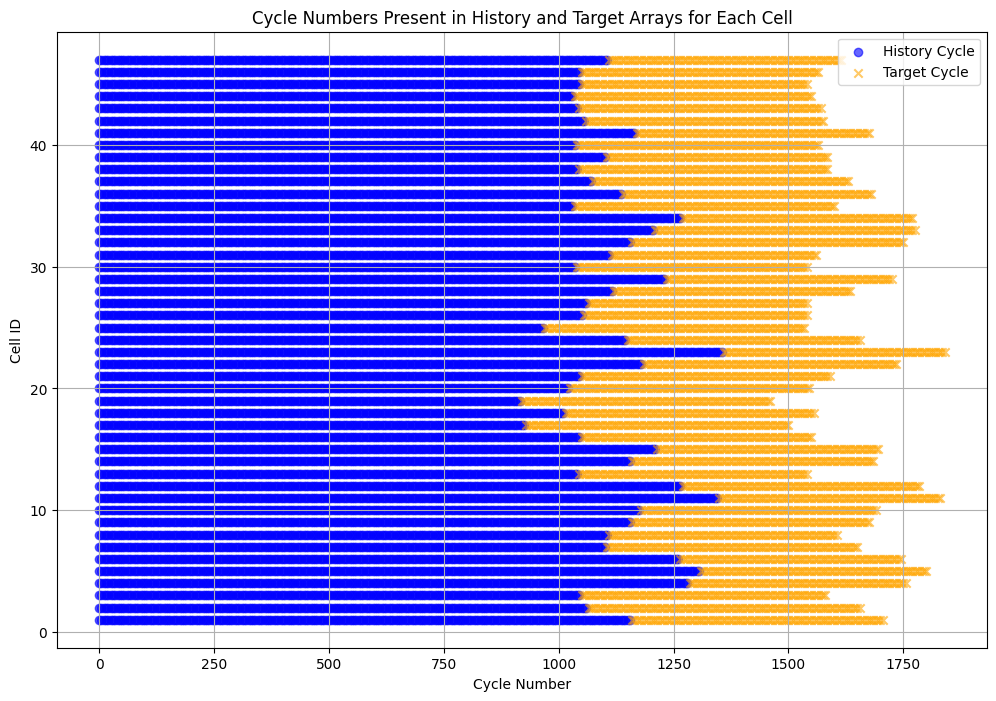

In [15]:
# Initialize a dictionary to store cycle numbers for visualization
cycle_numbers = {"Cell": [], "Cycle_Number": [], "Type": []}

# Find the maximum cell id from df_valid
max_cell_id = df_valid["Cell"].max()

# Loop through all the cells
for i in range(1, max_cell_id + 1):
    # Filter df_valid for the current cell
    df_cell_i = df_valid[df_valid["Cell"] == i]
    
    # Get the last sample for this cell
    last_sample = df_cell_i.iloc[-1]
    
    # Extract history_cycle and target_cycle arrays
    history_cycle = np.array(last_sample["History_Cycle"])
    target_cycle = np.array(last_sample["Target_Cycle_Expanded"])
    
    # Add cycle numbers and types to the dictionary
    cycle_numbers["Cell"].extend([i] * len(history_cycle))
    cycle_numbers["Cycle_Number"].extend(history_cycle)
    cycle_numbers["Type"].extend(["History"] * len(history_cycle))
    
    cycle_numbers["Cell"].extend([i] * len(target_cycle))
    cycle_numbers["Cycle_Number"].extend(target_cycle)
    cycle_numbers["Type"].extend(["Target"] * len(target_cycle))

# Convert the cycle numbers dictionary into a DataFrame
cycle_df = pd.DataFrame(cycle_numbers)

# Plot the data
plt.figure(figsize=(12, 8))

# Plot History_Cycle
plt.scatter(
    cycle_df[cycle_df["Type"] == "History"]["Cycle_Number"],
    cycle_df[cycle_df["Type"] == "History"]["Cell"],
    label="History Cycle",
    alpha=0.6,
    color="blue",
    marker="o"
)

# Plot Target_Cycle
plt.scatter(
    cycle_df[cycle_df["Type"] == "Target"]["Cycle_Number"],
    cycle_df[cycle_df["Type"] == "Target"]["Cell"],
    label="Target Cycle",
    alpha=0.6,
    color="orange",
    marker="x"
)

# Customize the plot
plt.xlabel("Cycle Number")
plt.ylabel("Cell ID")
plt.title("Cycle Numbers Present in History and Target Arrays for Each Cell")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Create a Plotly figure
fig = go.Figure()

# Find the maximum cell id from df_valid
max_cell_id = df_valid["Cell"].max()

# Loop through all the cells
for i in range(1, max_cell_id + 1):
    # Filter df_valid for the current cell
    df_cell_i = df_valid[df_valid["Cell"] == i]
    
    # Get the last sample for this cell
    last_sample = df_cell_i.iloc[-1]
    
    # Extract history and history_cycle arrays
    history_data = np.array(last_sample["History"])
    history_cycle = np.array(last_sample["History_Cycle"])
    
    # Add a line trace for the current cell
    fig.add_trace(go.Scatter(
        x=history_cycle,
        y=history_data,
        mode='lines',
        name=f'Cell {i}'
    ))

# Customize layout
fig.update_layout(
    title="Interactive Line Plot of History Values vs. History Cycle Across Cells",
    xaxis_title="History Cycle",
    yaxis_title="History Value",
    legend_title="Cells",
    template="plotly_white"
)

# Show the interactive plot
fig.show()

In [19]:
# Filter df_valid for the first cell
df_valid_cell_1 = df_valid[df_valid["Cell"] == 1]

# Get the last sample for the first cell
last_sample = df_valid_cell_1.iloc[-1]

# Extract history and history_cycle arrays
history_data = np.array(last_sample["History"])
history_cycle = np.array(last_sample["History_Cycle"])

# Extract target and target_cycle arrays
target_data = np.array(last_sample["Target_expanded"])
target_cycle = np.array(last_sample["Target_Cycle_Expanded"])

# Create the Plotly figure
fig = go.Figure()

# Add the history data with markers
fig.add_trace(go.Scatter(
    x=history_cycle,
    y=history_data,
    mode='lines+markers',  # Adds both lines and markers
    name='History Data',
    line=dict(color='blue'),
    marker=dict(size=4)  # Marker size for better visibility
))

# Add the target data with markers
fig.add_trace(go.Scatter(
    x=target_cycle,
    y=target_data,
    mode='lines+markers',  # Adds both lines and markers
    name='Target Data',
    line=dict(color='red'),
    marker=dict(size=4)  # Marker size for better visibility
))

# Customize the layout
fig.update_layout(
    title='History and Target Data for Cell 1',
    xaxis_title='Cycle Number',
    yaxis_title='Data Value',
    legend_title='Data Type',
    template='plotly_white',
    showlegend=True
)

# Show the interactive plot
fig.show()

## Eol 80 Distribution

In [161]:
# Fetch out the eol80 value for each distingt cell number
eol80_values = df_valid.groupby("Cell")["EOL80"].first()

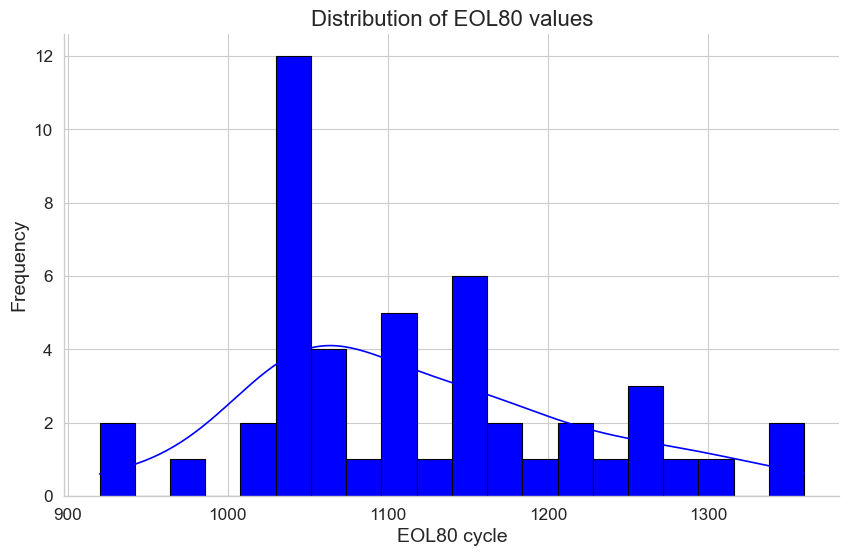

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the context and style for the plot
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# Create a figure for the histogram
plt.figure(figsize=(10, 6))

# Plot the histogram with KDE
sns.histplot(eol80_values, bins=20, kde=True, color="blue", edgecolor="black",
             alpha=1)

# Set the labels and title
plt.xlabel("EOL80 cycle", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of EOL80 values", fontsize=16)

# Remove the top and right spines from the plot
sns.despine()

# Save the figure
plt.savefig("EOL80_histogram.eps", format="eps", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()

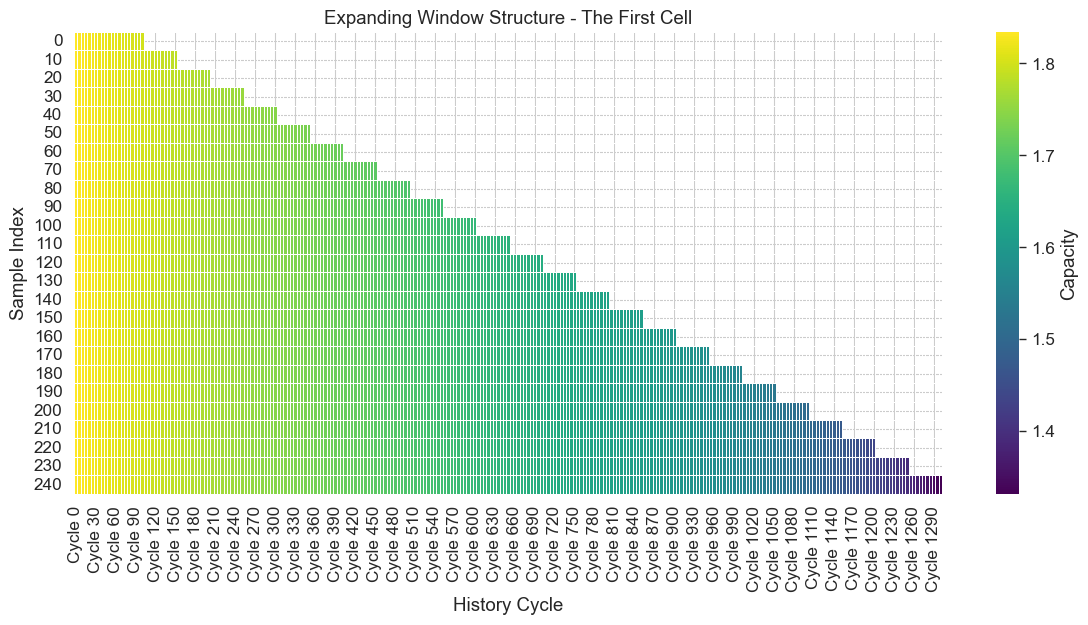

In [167]:
## Every 10 row for the first cell

# Extract all rows referring to the first cell
df_cell1 = df[df["Cell"] == 1]

# 10th sample
df_cell1 = df_cell1[::10]

# Extract unique history cycles from the dataframe
history_cycles = sorted(set(cycle for sublist in df_cell1["History_Cycle"] for cycle in sublist))

# Initialize the expanding matrix with
expanding_matrix_seaborn = np.full((len(df_cell1), len(history_cycles)), np.nan)

# Filling in the matrix with 1s where history cycles exist
for i, (history, values) in enumerate(zip(df_cell1["History_Cycle"], df_cell1["History"])):
    indices = [history_cycles.index(cycle) for cycle in history]
    expanding_matrix_seaborn[i, indices] = values

# Convert to DataFrame for visualization
expanding_df_seaborn = pd.DataFrame(
    expanding_matrix_seaborn,
    index=df_cell1.index,
    columns=[f"Cycle {cycle}" for cycle in history_cycles]
)

# Plot heatmap using Seaborn
plt.figure(figsize=(14, 6))
sns.heatmap(expanding_df_seaborn, cmap="viridis", linewidths=0.5, 
            cbar_kws={"label": "Capacity"})

plt.xlabel("History Cycle")
plt.ylabel("Sample Index")
plt.title("Expanding Window Structure - The First Cell")

# Display plot
plt.show()


In [168]:
# Every 10th row for the first 3 cells

# Extract all rows referring to the first 3 cells
df_cells_1_3 = df[df["Cell"].isin([1, 2, 3])]

df_cells_1_3.shape

df_cells_1_3

,Cell,Sample,History_Cycle,History,Target_Cycle_Expanded,Target_expanded,Target_Cycle,Target
0,1,1,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[105, 110, 115, 120, 125, 130, 135, 140, 145, ...","[1.7973466099593307, 1.7957194104838883, 1.794...","[105, 150, 195, 240, 285, 330, 375, 420, 465, ...","[1.7973466099593307, 1.7832393947563925, 1.770..."
1,1,2,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[110, 115, 120, 125, 130, 135, 140, 145, 150, ...","[1.7957194104838883, 1.794106179214274, 1.7925...","[110, 155, 200, 245, 290, 335, 380, 425, 470, ...","[1.7957194104838883, 1.7817527911332156, 1.769..."
2,1,3,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[115, 120, 125, 130, 135, 140, 145, 150, 155, ...","[1.794106179214274, 1.7925073295393719, 1.7909...","[115, 160, 205, 250, 295, 340, 385, 430, 475, ...","[1.794106179214274, 1.7802836132202329, 1.7676..."
3,1,4,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[120, 125, 130, 135, 140, 145, 150, 155, 160, ...","[1.7925073295393719, 1.7909232748480652, 1.789...","[120, 165, 210, 255, 300, 345, 390, 435, 480, ...","[1.7925073295393719, 1.7788295719024707, 1.766..."
4,1,5,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.834012342776987, 1.8321873038112761, 1.8303...","[125, 130, 135, 140, 145, 150, 155, 160, 165, ...","[1.7909232748480652, 1.7893544285292378, 1.787...","[125, 170, 215, 260, 305, 350, 395, 440, 485, ...","[1.7909232748480652, 1.7773897124807985, 1.765..."
...,...,...,...,...,...,...,...,...
683,3,684,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.840036111156223, 1.8372405290428224, 1.8344...","[1160, 1165, 1170, 1175, 1180, 1185, 1190, 119...","[1.3787848309155957, 1.3725568191851223, 1.366...","[1160, 1205, 1250, 1295, 1340, 1385, 1430, 147...","[1.3787848309155957, 1.3190293825982502, 1.256..."
684,3,685,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.840036111156223, 1.8372405290428224, 1.8344...","[1165, 1170, 1175, 1180, 1185, 1190, 1195, 120...","[1.3725568191851223, 1.3661965335902326, 1.359...","[1165, 1210, 1255, 1300, 1345, 1390, 1435, 148...","[1.3725568191851223, 1.3120645559634159, 1.250..."
685,3,686,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.840036111156223, 1.8372405290428224, 1.8344...","[1170, 1175, 1180, 1185, 1190, 1195, 1200, 120...","[1.3661965335902326, 1.3597165755163543, 1.353...","[1170, 1215, 1260, 1305, 1350, 1395, 1440, 148...","[1.3661965335902326, 1.3050808679330113, 1.243..."
686,3,687,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[1.840036111156223, 1.8372405290428224, 1.8344...","[1175, 1180, 1185, 1190, 1195, 1200, 1205, 121...","[1.3597165755163543, 1.3531295463489144, 1.346...","[1175, 1220, 1265, 1310, 1355, 1400, 1445, 149...","[1.3597165755163543, 1.298090919892464, 1.2369..."


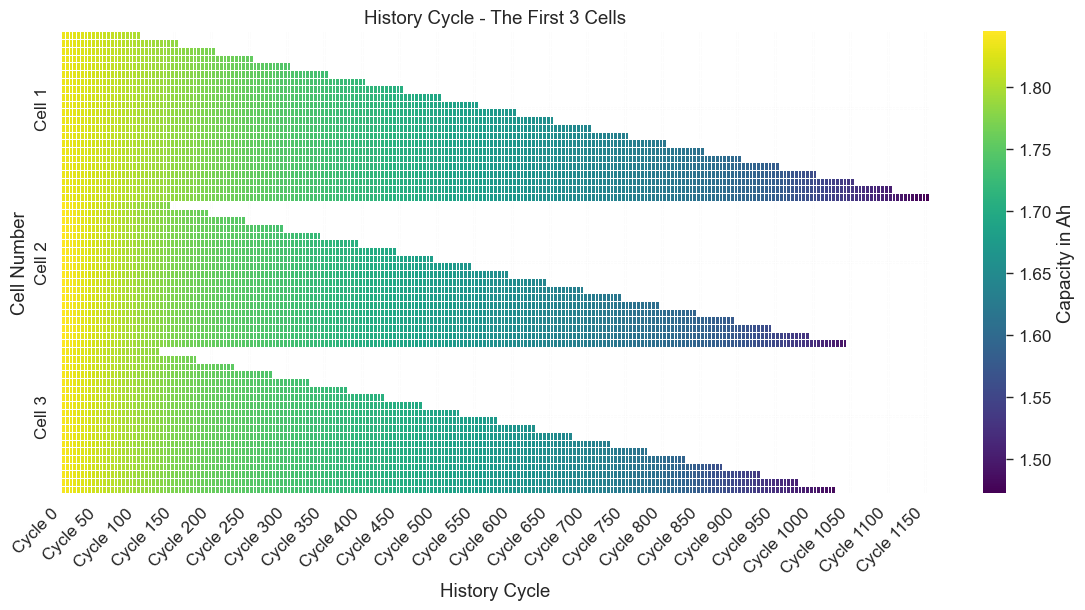

In [180]:
# Every 10th row for the first 3 cells

# Extract all rows referring to the first 3 cells
df_cells_1_3 = df_valid[df_valid["Cell"].isin([1, 2, 3])]

# 10th sample
df_cells_1_3 = df_cells_1_3[::10]

# Extract unique history cycles from the dataframe
history_cycles = sorted(set(cycle for sublist in df_cells_1_3["History_Cycle"] for cycle in sublist))

# Initialize the expanding matrix with
expanding_matrix_seaborn = np.full((len(df_cells_1_3), len(history_cycles)), np.nan)

# Filling in the matrix with 1s where history cycles exist
for i, (history, values) in enumerate(zip(df_cells_1_3["History_Cycle"], df_cells_1_3["History"])):
    indices = [history_cycles.index(cycle) for cycle in history]
    expanding_matrix_seaborn[i, indices] = values

# Convert to DataFrame for visualization
expanding_df_seaborn = pd.DataFrame(
    expanding_matrix_seaborn,
    index=df_cells_1_3["Cell"],
    columns=[f"Cycle {cycle}" for cycle in history_cycles]
)

cycle_interval = 10  # Use every 5th instance

# Select the cycles to display as labels (every 5th or the last one)
cycle_ticks = [history_cycles[i] for i in range(0, len(history_cycles), cycle_interval)]
if history_cycles[-1] not in cycle_ticks: # Add last cycle if not already included
    cycle_ticks.append(history_cycles[-1])

cycle_labels = [f"Cycle {cycle}" for cycle in cycle_ticks]

# Set up the figure size
plt.figure(figsize=(14, 6))

# Create a mask to hide NaN values
mask = np.isnan(expanding_df_seaborn)

# Plot heatmap using Seaborn
sns.heatmap(expanding_df_seaborn, cmap="viridis", mask=mask, linewidths=0.5, 
            cbar_kws={"label": "Capacity in Ah"})

# Labels and title
plt.yticks(ticks=[10, 30, 50], labels=["Cell 1", "Cell 2", "Cell 3"])
plt.xticks(np.arange(0, len(history_cycles), cycle_interval), cycle_labels, rotation=45, ha="right")
plt.xlabel("History Cycle")
plt.ylabel("Cell Number")
plt.title("History Cycle - The First 3 Cells")

# Save the plot
plt.savefig("plot/Expanding_Window_Structure.eps", format="eps", bbox_inches="tight", dpi=300)


# Show plot
plt.show()